In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# ------------------
# Parameters
# ------------------
N_arr = np.arange(2, 12, 2)
nmax  = 20
ω = ω0 = g = 1.0
tlist = np.arange(0.01, 2*np.pi, 0.1)

# ------------------
# Tavis–Cummings Hamiltonian
# ------------------
def tavis_cummings(N, nmax, ω, ω0, g):

    a  = qt.destroy(nmax)
    Ic = qt.qeye(nmax)

    sp, sm, sz = qt.sigmap(), qt.sigmam(), qt.sigmaz()

    def embed(op, i):
        ops = [qt.qeye(2)]*N
        ops[i] = op
        return qt.tensor(ops)

    Sp = sum(embed(sp, i) for i in range(N))
    Sm = Sp.dag()
    Sz = 0.5 * sum(embed(sz, i) for i in range(N))

    IB = qt.tensor([qt.qeye(2)]*N)
    HB = ω0 * Sz

    H = (
        ω * qt.tensor(a.dag()*a, IB)
        + qt.tensor(Ic, HB)
        + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm))
    )

    return H, HB

# ------------------
# Initial state
# ------------------
def initial_state(N, nmax, state):

    if state == "coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state == "fock":
        psiA = qt.basis(nmax, N)

    psiB = qt.tensor([qt.basis(2, 1) for _ in range(N)])
    return qt.tensor(psiA, psiB)

# ------------------
# Pnm-based ergotropy
# ------------------
def pnm_matrix(rho, H):

    r_val, r_vec = rho.eigenstates()
    idx = np.argsort(r_val)[::-1]
    r_val = r_val[idx]
    r_vec = [r_vec[i] for i in idx]

    e_val, e_vec = H.eigenstates()

    pnm = np.zeros((len(e_val), len(r_val)))
    for n in range(len(e_val)):
        for m in range(len(r_val)):
            pnm[n, m] = abs(e_vec[n].overlap(r_vec[m]))**2

    return pnm, r_val, e_val

def ergotropy_pnm(pnm, r_val, e_val):
    e_m = e_val[:len(r_val)]
    return np.sum(r_val[None, :] * pnm * (e_val[:, None] - e_m[None, :]))

def variance_pnm(pnm, r_val, e_val):
    e_m = e_val[:len(r_val)]
    mean2 = np.sum(r_val[None, :] * pnm * (e_val[:, None] - e_m[None, :])**2)
    mean  = ergotropy_pnm(pnm, r_val, e_val)
    return mean2 - mean**2

N= 2, τ=0.910, E_B=0.272
N= 4, τ=0.710, E_B=0.846
N= 6, τ=0.610, E_B=1.495
N= 8, τ=0.510, E_B=2.005
N=10, τ=0.510, E_B=2.946


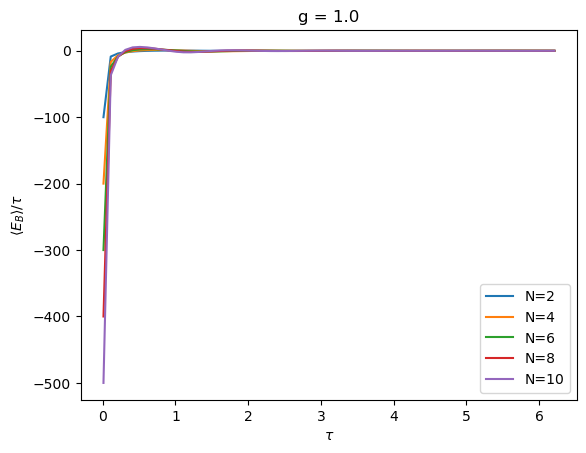

In [2]:

# ------------------
# Main loop
# ------------------
τ_list = []

for N in N_arr:

    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    HB_full = qt.tensor(qt.qeye(nmax), HB)

    ψ0 = initial_state(N, nmax, "coherent")

    result = qt.sesolve(H, ψ0, tlist, e_ops=HB_full)
    Eb = np.array(result.expect[0])

    power = Eb / tlist
    idx = np.argmax(power)

    τ_list.append(tlist[idx])

    print(f"N={N:2d}, τ={tlist[idx]:.3f}, E_B={Eb[idx]:.3f}")

    plt.plot(tlist, power, label=f"N={N}")

plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle E_B\rangle/\tau$")
plt.legend()
plt.title(f"g = {g}")
plt.show()

N= 2, τ=0.910, Ergotropy=1.567908, Variance=3.383888e-01
N= 4, τ=0.710, Ergotropy=3.654145, Variance=3.164684e-01
N= 6, τ=0.610, Ergotropy=5.700164, Variance=2.929291e-01
N= 8, τ=0.510, Ergotropy=7.722579, Variance=2.549164e-01
N=10, τ=0.510, Ergotropy=9.753880, Variance=2.606668e-01


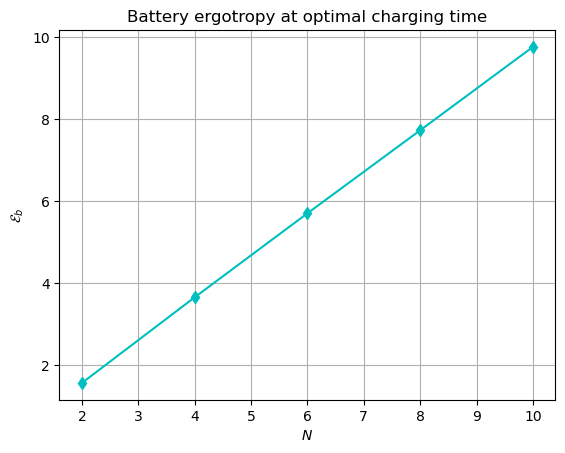

In [3]:
erg_list = []
var_list = []

for N, τ in zip(N_arr, τ_list):

    # Rebuild Hamiltonian
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)

    # Initial state
    ψ0 = initial_state(N, nmax, "coherent")

    # Evolve until τ
    result = qt.sesolve(H, ψ0, [0, τ])

    # Full density matrix at τ
    ρ_full = result.states[-1].proj()

    # Partial trace over cavity
    ρb = ρ_full.ptrace(1)

    # Ergotropy via pnm matrix
    pnm, r_val, e_val = pnm_matrix(ρb, HB)

    erg = ergotropy_pnm(pnm, r_val, e_val)
    var = variance_pnm(pnm, r_val, e_val)

    print(f"N={N:2d}, τ={τ:.3f}, Ergotropy={erg:.6f}, Variance={var:.6e}")

    erg_list.append(erg)
    var_list.append(var)

# ------------------
# Plot
# ------------------
plt.figure()
plt.plot(N_arr[:len(erg_list)], erg_list, 'd-', color='c')
plt.xlabel(r"$N$")
plt.ylabel(r"$\mathcal{E}_b$")
plt.title("Battery ergotropy at optimal charging time")
plt.grid()
plt.show()

N= 2, τ=0.910, Erg / <EB>=35.272152
N= 4, τ=0.710, Erg / <EB>=11.354788
N= 6, τ=0.610, Erg / <EB>=6.421639
N= 8, τ=0.510, Erg / <EB>=4.732670
N=10, τ=0.510, Erg / <EB>=3.260114


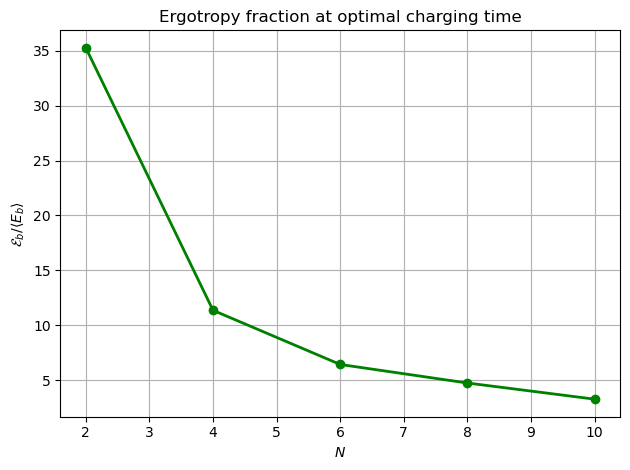

In [4]:
erg_list = []
Eb_list  = []

for i, N in enumerate(N_arr):

    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    psi0  = initial_state(N, nmax, "coherent")

    result = qt.sesolve(H, psi0, [0, τ_list[i]])
    rho = result.states[-1]

    # FIX: trace out cavity only
    rho_b = rho.ptrace(list(range(1, len(rho.dims[0]))))

    Eb  = qt.expect(HB, rho_b)
    erg = ergotropy_pnm(pnm, r_val, e_val)

    Eb_list.append(Eb)
    erg_list.append(erg)

Eb_arr  = np.array(Eb_list)
erg_arr = np.array(erg_list)

ratio = erg_arr / (Eb_arr + 1e-20)

for i, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[i]:.3f}, Erg / <EB>={ratio[i]:.6f}")

plt.figure()
plt.plot(N_arr, ratio, 'o-', color='g', linewidth=2)
plt.xlabel(r"$N$")
plt.ylabel(r"$\mathcal{E}_b / \langle E_b \rangle$")
plt.title("Ergotropy fraction at optimal charging time")
plt.grid(True)
plt.tight_layout()
plt.show()

N= 2, τ=0.910, Relative Fluctuation =0.059639
N= 4, τ=0.710, Relative Fluctuation =0.057675
N= 6, τ=0.610, Relative Fluctuation =0.055489
N= 8, τ=0.510, Relative Fluctuation =0.051763
N=10, τ=0.510, Relative Fluctuation =0.052344


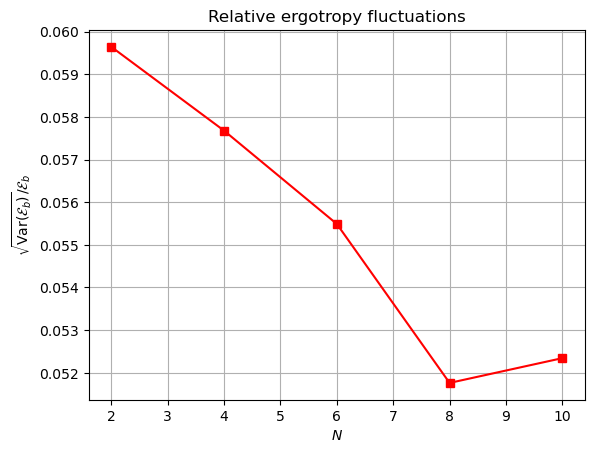

In [6]:
erg_arr = np.array(erg_list)
var_arr = np.array(var_list)

####################################################
# Plot fluctuations as function of g for different N 
####################################################

rel_fluct = np.sqrt(np.array(var_list)) / np.array(erg_list)

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Relative Fluctuation ={rel_fluct[idx]:.6f}")

plt.figure()
plt.plot(N_arr, rel_fluct, 's-', color='r')
plt.xlabel(r"$N$")
plt.ylabel(r"$\sqrt{\mathrm{Var}(\mathcal{E}_b)}/\mathcal{E}_b$")
plt.title("Relative ergotropy fluctuations")
plt.grid()
plt.show()